In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data import - csv with prices and sentiments

In [2]:
import pandas as pd
csv3=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DATA_1/final_data_master.csv")

In [3]:
csv3.dtypes

Unnamed: 0      int64
dates          object
prices        float64
sentiment     float64
dtype: object

In [4]:
csv3['dates'] =  pd.to_datetime(csv3['dates'], format='%Y-%m-%d')

In [5]:
csv3.dtypes

Unnamed: 0             int64
dates         datetime64[ns]
prices               float64
sentiment            float64
dtype: object

Sorting values by datetime -> newest on the bottom

In [6]:
csv3.sort_values(by=['dates'], ascending=True, inplace=True)

In [7]:
csv3.reset_index(inplace=True)

In [8]:
csv3.pop("Unnamed: 0")

0          0
1          1
2          2
3          3
4          4
        ... 
2103    2103
2104    2104
2105    2105
2106    2106
2107    2107
Name: Unnamed: 0, Length: 2108, dtype: int64

In [9]:
csv3.pop("index")

0          0
1          1
2          2
3          3
4          4
        ... 
2103    2103
2104    2104
2105    2105
2106    2106
2107    2107
Name: index, Length: 2108, dtype: int64

In [10]:
csv3

,dates,prices,sentiment
0,2014-09-17,457.334015,0.011888
1,2014-09-18,424.440002,0.010501
2,2014-09-19,394.795990,0.004012
3,2014-09-20,408.903992,0.011305
4,2014-09-21,398.821014,0.003570
...,...,...,...
2103,2022-11-14,16618.199219,0.114216
2104,2022-11-15,16884.613281,0.105882
2105,2022-11-16,16669.439453,0.097629
2106,2022-11-20,16291.832031,0.073256


Data exploration.

In [11]:
csv3.describe()

,prices,sentiment
count,2108.000000,2108.000000
mean,7212.931322,0.048334
std,11915.777855,0.043241
min,178.102997,-0.044501
25%,424.180741,0.021111
50%,3184.444946,0.036511
75%,8201.771728,0.064705
max,65992.835938,0.417764


Correlation score between Twitter sentiments and BTC prices: 0,77!

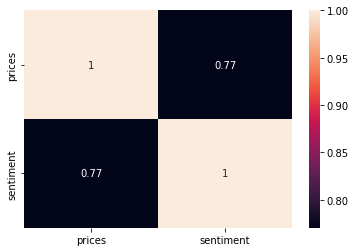

In [12]:
import seaborn as sn
corr_matrix = csv3.corr()
sn.heatmap(corr_matrix, annot=True)

Data visualization - sentiment and prices

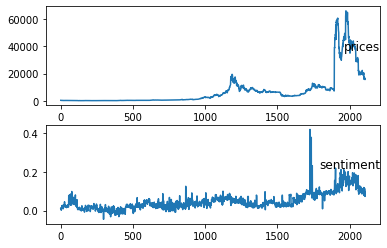

In [13]:
from matplotlib import pyplot
values = csv3.values
groups = [1,2]
i =1  
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1,i)
    pyplot.plot(values[:,group])
    pyplot.title(csv3.columns[group], y=.5, loc='right')
    i += 1
pyplot.show()

Data Preparation

In [14]:
values = csv3.values
cols = csv3.columns.tolist()
cols = cols[-1:] + cols[:-1]
cols

['sentiment', 'dates', 'prices']

Building a new csv for ML purposes - we need to drop the datetime values

In [15]:
csv3 = csv3[cols]
csv3 = csv3[['prices', 'sentiment']]
csv3.head()

,prices,sentiment
0,457.334015,0.011888
1,424.440002,0.010501
2,394.795990,0.004012
3,408.903992,0.011305
4,398.821014,0.003570


We're building the model on two variables - price and sentiment.
Our array will look like that:

In [16]:
csv3.values

array([[4.57334015e+02, 1.18876342e-02],
       [4.24440002e+02, 1.05007360e-02],
       [3.94795990e+02, 4.01234314e-03],
       ...,
       [1.66694395e+04, 9.76292044e-02],
       [1.62918320e+04, 7.32564884e-02],
       [1.57872842e+04, 9.53884513e-02]])

Preparing a scaler with a desired range of transformed features as (0,1)

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(csv3.values)

Our array scaled with values between 0 and 1

In [18]:
scaled

array([[0.00424268, 0.1219836 ],
       [0.00374289, 0.11898337],
       [0.00329247, 0.10494727],
       ...,
       [0.25057211, 0.30746514],
       [0.24483468, 0.25474055],
       [0.2371685 , 0.30261781]])

LSTM preparation

Importing needed libraries

In [19]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Defining a function that will convert imput data to a dataframe for supervised learning

Explanation via https://ruslanmv.com/blog/Multivariable-Time-Series-Forecasting-with-Neural-Networks

Technically, in time series forecasting terminology the current time (t) and future times (t+1, t+n) are forecast times and past observations (t-1, t-n) are used to make forecasts.

Positive and negative shifts can be used to create a new DataFrame from a time series with sequences of input and output patterns for a supervised learning problem. Further, the shift function also works on so-called multivariate time series problems. All variates in the time series can be shifted forward or backward to create multivariate input and output sequences.

In [20]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Defining params

In [21]:
n_days = 60 #timeshift for the supervised dataframe
n_features = 2 #we have 2 variables in our array
n_obs = n_days*n_features #output count of all observations in the supervised df

Calling the function

In [22]:
reframed = series_to_supervised(scaled, n_days, 1)
reframed.head()

,var1(t-60),var2(t-60),var1(t-59),var2(t-59),var1(t-58),var2(t-58),var1(t-57),var2(t-57),var1(t-56),var2(t-56),...,var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
60,0.004243,0.121984,0.003743,0.118983,0.003292,0.104947,0.003507,0.120723,0.003354,0.103991,...,0.003730,0.238220,0.003687,0.204093,0.003338,0.236340,0.003009,0.212194,0.003187,0.199299
61,0.003743,0.118983,0.003292,0.104947,0.003507,0.120723,0.003354,0.103991,0.003404,0.132904,...,0.003687,0.204093,0.003338,0.236340,0.003009,0.212194,0.003187,0.199299,0.003180,0.170221
62,0.003292,0.104947,0.003507,0.120723,0.003354,0.103991,0.003404,0.132904,0.003915,0.119527,...,0.003338,0.236340,0.003009,0.212194,0.003187,0.199299,0.003180,0.170221,0.002995,0.275026
63,0.003507,0.120723,0.003354,0.103991,0.003404,0.132904,0.003915,0.119527,0.003724,0.140501,...,0.003009,0.212194,0.003187,0.199299,0.003180,0.170221,0.002995,0.275026,0.003076,0.194834
64,0.003354,0.103991,0.003404,0.132904,0.003915,0.119527,0.003724,0.140501,0.003547,0.151466,...,0.003187,0.199299,0.003180,0.170221,0.002995,0.275026,0.003076,0.194834,0.002731,0.202770


Our model will predict the actual price (last from the obs columns), so we need to drop both actual price and actual sentiment from the dataframe

In [23]:
reframed.drop(reframed.columns[[121,120]], axis=1, inplace=True)
reframed.head()

,var1(t-60),var2(t-60),var1(t-59),var2(t-59),var1(t-58),var2(t-58),var1(t-57),var2(t-57),var1(t-56),var2(t-56),...,var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1)
60,0.004243,0.121984,0.003743,0.118983,0.003292,0.104947,0.003507,0.120723,0.003354,0.103991,...,0.002881,0.265879,0.003730,0.238220,0.003687,0.204093,0.003338,0.236340,0.003009,0.212194
61,0.003743,0.118983,0.003292,0.104947,0.003507,0.120723,0.003354,0.103991,0.003404,0.132904,...,0.003730,0.238220,0.003687,0.204093,0.003338,0.236340,0.003009,0.212194,0.003187,0.199299
62,0.003292,0.104947,0.003507,0.120723,0.003354,0.103991,0.003404,0.132904,0.003915,0.119527,...,0.003687,0.204093,0.003338,0.236340,0.003009,0.212194,0.003187,0.199299,0.003180,0.170221
63,0.003507,0.120723,0.003354,0.103991,0.003404,0.132904,0.003915,0.119527,0.003724,0.140501,...,0.003338,0.236340,0.003009,0.212194,0.003187,0.199299,0.003180,0.170221,0.002995,0.275026
64,0.003354,0.103991,0.003404,0.132904,0.003915,0.119527,0.003724,0.140501,0.003547,0.151466,...,0.003009,0.212194,0.003187,0.199299,0.003180,0.170221,0.002995,0.275026,0.003076,0.194834


Training data preparation 20-80

In [24]:
split_rows_when=int(round(len(csv3["prices"])*(0.8),0))

Number of last considered day in training dataset

In [25]:
split_rows_when

1686

In [26]:
values = reframed.values
train = values[:split_rows_when, :]

In [27]:
train = values[:split_rows_when, :]
test = values[split_rows_when:, :]
train.shape

(1686, 120)

In [28]:
#defining the training x,y and test x,y
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

Reshaping - as LSTM needs the data to be 3-dimensional, we will consider given dimensions:


*   Samples (actual data)
*   Sequence count - sequence of days to calculate the actual price from (60)
*   Number of variables (2)






In [29]:
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1686, 60, 2) (1686,) (362, 60, 2) (362,)


Implementing LSTM neural network

In [30]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

#overview of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 32,101
Trainable params: 32,101
Non-trainable params: 0
_________________________________________________________________


In [31]:
#defining a history variable to see which epochs had minimal loss
history = model.fit(train_X, train_y, epochs=50, batch_size=6, validation_data=(test_X, test_y), verbose=2, shuffle=False,validation_split=0.2)

Epoch 1/50
281/281 - 10s - loss: 0.0098 - val_loss: 0.2714 - 10s/epoch - 34ms/step
Epoch 2/50
281/281 - 6s - loss: 0.0169 - val_loss: 0.2669 - 6s/epoch - 21ms/step
Epoch 3/50
281/281 - 6s - loss: 0.0197 - val_loss: 0.2710 - 6s/epoch - 20ms/step
Epoch 4/50
281/281 - 5s - loss: 0.0221 - val_loss: 0.3021 - 5s/epoch - 19ms/step
Epoch 5/50
281/281 - 6s - loss: 0.0191 - val_loss: 0.3019 - 6s/epoch - 20ms/step
Epoch 6/50
281/281 - 6s - loss: 0.0197 - val_loss: 0.3136 - 6s/epoch - 20ms/step
Epoch 7/50
281/281 - 6s - loss: 0.0191 - val_loss: 0.3170 - 6s/epoch - 20ms/step
Epoch 8/50
281/281 - 6s - loss: 0.0189 - val_loss: 0.3194 - 6s/epoch - 20ms/step
Epoch 9/50
281/281 - 6s - loss: 0.0191 - val_loss: 0.3202 - 6s/epoch - 20ms/step
Epoch 10/50
281/281 - 6s - loss: 0.0194 - val_loss: 0.3222 - 6s/epoch - 21ms/step
Epoch 11/50
281/281 - 8s - loss: 0.0186 - val_loss: 0.3108 - 8s/epoch - 27ms/step
Epoch 12/50
281/281 - 6s - loss: 0.0193 - val_loss: 0.3038 - 6s/epoch - 21ms/step
Epoch 13/50
281/281 - 5

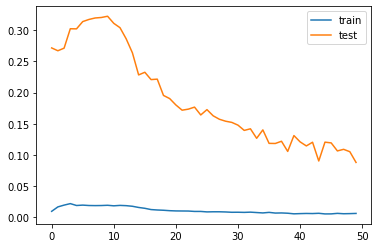

In [32]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Let's see how we have to reshape some of the variables to make and evaluate predictions

In [33]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1686, 60, 2) (1686,) (362, 60, 2) (362,)


Making predictions with the model

In [34]:
import numpy as np
yhat = model.predict(test_X)
#reshaping test_X for predicting the actual prices
test_X = test_X.reshape((test_X.shape[0], n_days * n_features, ))

12/12 [==============================] - 1s 12ms/step


Inverse scaling predictions of our model

In [35]:
# -1 because we are considering all rows but only last value of them - as it is the actual predicted price, not the sentiment value for a given day
inv_yhat = concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

Inverse scaling actual data 

In [36]:
test_y = test_y.reshape((len(test_y), 1))
#again we are considering only the last variable as it is the actual price, not the sentiment (note that we had both sentiments and prices in the input data)
inv_y = concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)

MODEL EVALUATION

In [37]:
mse = (mean_squared_error(inv_y, inv_yhat))
print('Model MSE: %.3f' % mse)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Model RMSE: %.3f' % rmse)

Model MSE: 46274967.098
Model RMSE: 6802.571


Reshaping the actual data for visualization:
Again we are considering only the actual prices, not the actual sentiments

In [38]:
inv_y1 = inv_y[:,0]

Reshaping the predicted data for vis - only actual prices so that's why there's a 0

In [39]:
inv_yhat1 = inv_yhat[:,0]

Plotting the model

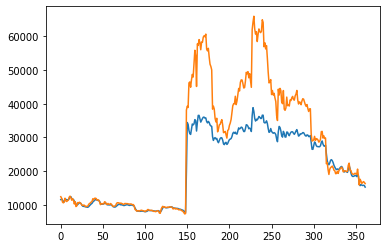

In [40]:
plt.plot(inv_yhat1, label='Predicted')
plt.plot(inv_y1, label='Actual')

Reshaping again as our pred and act are now in the shape of (x,) and we need them to be like (x,1)...

In [41]:
inv_yhat2=inv_yhat1.reshape(362,1)
inv_y2=inv_y1.reshape(362,1)

...For the act and pred dataframe to be built

In [42]:
import math
array_conc_eval_pred = np.concatenate((inv_y2,inv_yhat2),axis=1)

df_pred = pd.DataFrame(data = array_conc_eval_pred, columns=["actual", "predicted"])

df_pred

,actual,predicted
0,12407.332031,11547.978379
1,11959.371094,11762.473706
2,10817.155273,11426.278396
3,10583.134766,10992.779392
4,10801.677734,10881.552474
...,...,...
357,16353.365234,15852.128825
358,16618.199219,15724.278772
359,16884.613281,15805.332983
360,16669.439453,15728.597845


Creating the df as we did in previous part (3_model_I)

In [43]:
ar_test = np.repeat(1, len(inv_y2))
ar_pred = np.repeat(2, len(inv_yhat2))

df_test = pd.DataFrame(data = np.concatenate((inv_y2,(np.reshape(ar_test, (-1, 1)))),axis=1), columns=["price","act/pred"])
df_pred = pd.DataFrame(data = np.concatenate((inv_yhat2,(np.reshape(ar_pred, (-1, 1)))),axis=1), columns=["price","act/pred"])

df_both = [df_test, df_pred]
df_3 = pd.concat(df_both, ignore_index=False)

df_3["act/pred"].replace({1: "act", 2: "pred"}, inplace=True)
df_3.head(10)

,price,act/pred
0,12407.332031,act
1,11959.371094,act
2,10817.155273,act
3,10583.134766,act
4,10801.677734,act
5,11961.269531,act
6,11215.437500,act
7,10978.459961,act
8,11208.550781,act
9,11450.846680,act


Plotting the model - plotly express doesn't work in github preview so please import the file to google colab for this to work

In [44]:
import plotly.express as px
fig = px.line(df_3, x=df_3.index.values, y="price", color='act/pred', title='BTC Price')
fig.show()